In [9]:
# Install necessary libraries
!pip install tensorflow
!pip install keras
!pip install geopandas
!pip install folium
!pip install openpyxl

In [55]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Geospatial data handling
import geopandas as gpd
import folium
from folium.plugins import HeatMap

# Machine learning and preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Deep learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping




In [67]:

# Unzipping all the files in the zips
for file in os.listdir(path):
    if file.endswith('.zip'):
        with zipfile.ZipFile(os.path.join(path, file), 'r') as zip_ref:
            zip_ref.extractall(path)

# Concatenating all xlsx files in the data folder
all_files = glob.glob(os.path.join(path, "*.xlsx"))
data_frames = []

for file in all_files:
    data_frames.append(pd.read_excel(file))

data = pd.concat(data_frames, ignore_index=True)



In [68]:
data.head()

,CATEGORY,CALL GROUPS,final_case_type,CASE DESC,occ_date,x_coordinate,y_coordinate,census_tract
0,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY ...,2015-01-01,7624403,663901,30502.0
1,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY ...,2015-01-01,7626061,707425,4102.0
2,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY ...,2015-01-01,7626432,655739,6501.0
3,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY ...,2015-01-01,7638375,689076,4500.0
4,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY ...,2015-01-01,7640361,706981,3901.0


In [69]:
data.tail()

,CATEGORY,CALL GROUPS,final_case_type,CASE DESC,occ_date,x_coordinate,y_coordinate,census_tract
1032299,BURGLARY,PROPERTY CRIME,BURGP,BURGLARY - PRIORITY *H ...,2016-07-28,7644436,685008,5100.0
1032300,BURGLARY,PROPERTY CRIME,BURGP,BURGLARY - PRIORITY *H ...,2016-07-29,7644019,686939,5100.0
1032301,BURGLARY,PROPERTY CRIME,BURGP,BURGLARY - PRIORITY *H ...,2016-07-30,7669140,678601,1601.0
1032302,BURGLARY,PROPERTY CRIME,BURGP,BURGLARY - PRIORITY *H ...,2016-07-30,7671422,695799,7700.0
1032303,BURGLARY,PROPERTY CRIME,BURGP,BURGLARY - PRIORITY *H ...,2016-07-31,7685840,684298,9302.0


In [70]:
data.drop_duplicates(inplace=True)


In [72]:

# Check for missing values
print(data.isnull().sum())


CATEGORY               0
CALL GROUPS            0
final_case_type        0
CASE DESC              0
occ_date               0
x_coordinate           0
y_coordinate           0
census_tract       56475
dtype: int64


In [73]:

# Handle missing values
data = data.fillna(data.mode())


In [74]:

# Convert 'occ_date' to datetime
data['occ_date'] = pd.to_datetime(data['occ_date'])

# Extract temporal features
data['year'] = data['occ_date'].dt.year
data['month'] = data['occ_date'].dt.month
data['day'] = data['occ_date'].dt.day
data['day_of_week'] = data['occ_date'].dt.dayofweek


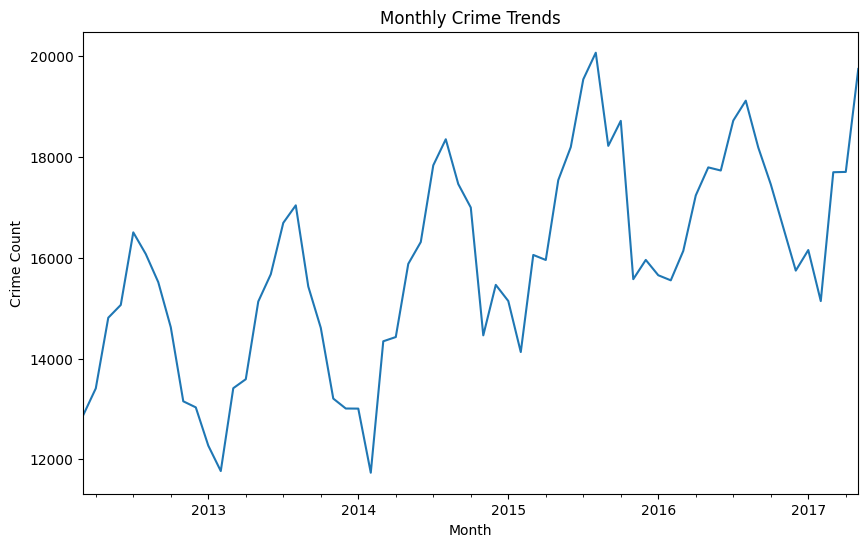

In [77]:

# Visualizations for crime trends
data['occ_date'].groupby(data['occ_date'].dt.to_period('M')).count().plot(
    kind='line', figsize=(10, 6), title="Monthly Crime Trends")
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.savefig("Monthly Crime Trends.png")
plt.show()


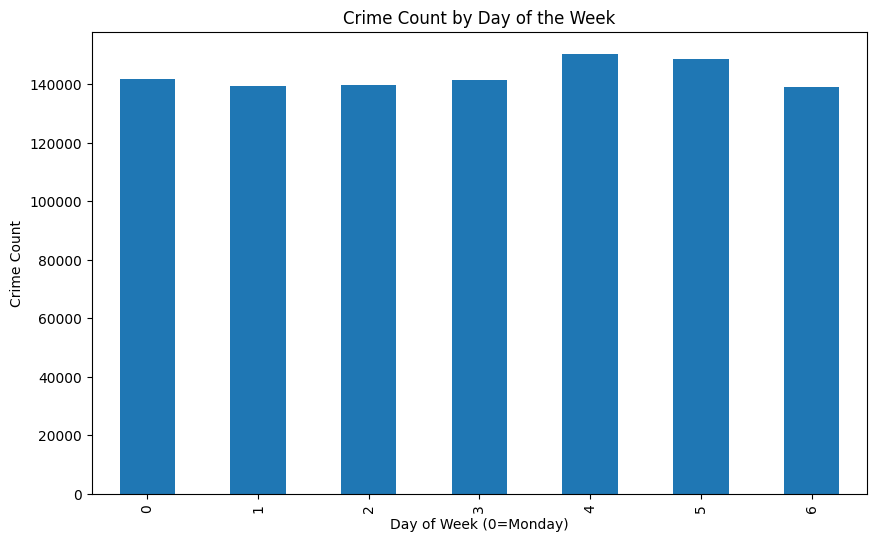

In [78]:

data['day_of_week'].value_counts().sort_index().plot(
    kind='bar', figsize=(10, 6), title="Crime Count by Day of the Week")
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Crime Count')
plt.savefig("Crime Count by Day of the Week.png")
plt.show()


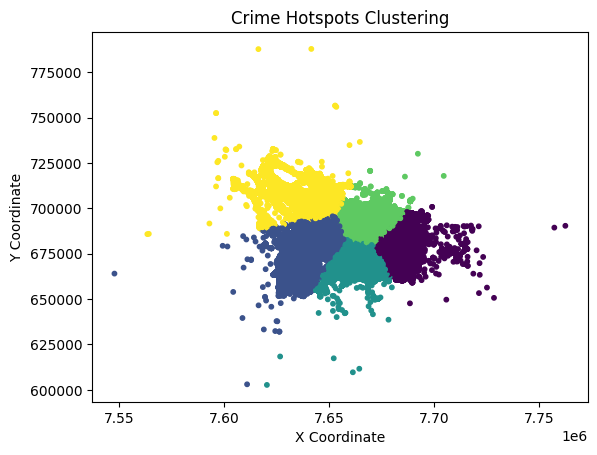

In [79]:

# Clustering crime data for hotspots
kmeans = KMeans(n_clusters=5, random_state=42).fit(data[['x_coordinate', 'y_coordinate']])
data['cluster'] = kmeans.labels_

plt.scatter(data['x_coordinate'], data['y_coordinate'], c=data['cluster'], cmap='viridis', s=10)
plt.title("Crime Hotspots Clustering")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.savefig("Crime Hotspots Clustering.png")
plt.show()


In [81]:

# Normalize spatial coordinates
scaler = MinMaxScaler()
data[['x_coordinate', 'y_coordinate']] = scaler.fit_transform(data[['x_coordinate', 'y_coordinate']])

# Encode categorical features
label_encoder = LabelEncoder()
data['CATEGORY'] = label_encoder.fit_transform(data['CATEGORY'])
data['CALL GROUPS'] = label_encoder.fit_transform(data['CALL GROUPS'])

# Define target column (binary classification)
data['target'] = (data['CATEGORY'] > data['CATEGORY'].median()).astype(int)


In [136]:

# Parameters
grid_size = 10
sequence_length = 14
batch_size = 16


In [137]:

def create_temporal_sequences(data, sequence_length, forecast_period=14):
    features = data[['month', 'day', 'day_of_week']].values
    targets = data['target'].values
    sequences = [features[i:i+sequence_length] for i in range(len(features) - sequence_length - forecast_period)]
    target_values = targets[sequence_length + forecast_period:]
    return np.array(sequences), np.array(target_values)

# Generate Spatial Grids
def generate_spatial_grids(data, grid_size):

    grid_x = (data['x_coordinate'] * grid_size).astype(int).clip(0, grid_size - 1)
    grid_y = (data['y_coordinate'] * grid_size).astype(int).clip(0, grid_size - 1)
    grid_data = np.zeros((len(data), grid_size, grid_size, 1))
    for i, (x, y) in enumerate(zip(grid_x, grid_y)):
        grid_data[i, x, y, 0] += 1
    return grid_data


In [138]:

# Filter data for March-May 2017 (test set)
test_start = pd.to_datetime('2017-03-01')
test_end = pd.to_datetime('2017-05-31')

# Split data
test_data_1 = data[(data['occ_date'] >= test_start) & (data['occ_date'] <= test_end)]
train_data_1 = data[(data['occ_date'] < test_start) | (data['occ_date'] > test_end)]


In [139]:
train_data = train_data_1.sample(n=50000, random_state=42)

In [140]:

test_data = test_data_1.sample(n=10000, random_state=42)

In [141]:

# Generate temporal sequences for train and test
lstm_train_data, lstm_train_targets = create_temporal_sequences(train_data, sequence_length, forecast_period=14)
lstm_test_data, lstm_test_targets = create_temporal_sequences(test_data, sequence_length, forecast_period=14)

# Generate spatial grids for train and test
cnn_train_data = generate_spatial_grids(train_data, grid_size)
cnn_test_data = generate_spatial_grids(test_data, grid_size)


In [142]:
min_length = min(len(cnn_train_data), len(lstm_train_targets))
cnn_train_data = cnn_train_data[:min_length]
lstm_train_targets = lstm_train_targets[:min_length]


In [143]:

# Split training data for CNN and LSTM
X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(cnn_train_data, lstm_train_targets, test_size=0.2, random_state=42)
X_train_lstm, X_test_lstm = train_test_split(lstm_train_data, test_size=0.2, random_state=42)


In [144]:

# Compute class weights for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))



In [145]:


input_cnn = layers.Input(shape=(grid_size, grid_size, 1))
cnn_out = layers.Conv2D(2, (3, 3), activation='relu')(input_cnn)
cnn_out = layers.MaxPooling2D((2, 2))(cnn_out)
cnn_out = layers.Flatten()(cnn_out)


In [146]:

# LSTM branch
lstm_input = layers.Input(shape=(sequence_length, 3))
lstm_out = layers.LSTM(4, return_sequences=False)(lstm_input)

# Combine branches
combined = layers.Concatenate()([cnn_out, lstm_out])
dense = layers.Dense(32, activation='relu')(combined)
output = layers.Dense(1, activation='sigmoid')(dense)

# Build and Compile Model
model = models.Model(inputs=[input_cnn, lstm_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [147]:

# Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [148]:
def data_generator(X_cnn, X_lstm, y, batch_size):
    while True:
        for start in range(0, len(X_cnn), batch_size):
            end = min(start + batch_size, len(X_cnn))
            yield [X_cnn[start:end], X_lstm[start:end]], y[start:end]

train_gen = data_generator(X_train_cnn, X_train_lstm, y_train, batch_size)
val_gen = data_generator(X_test_cnn, X_test_lstm, y_test, batch_size)


Epoch 1/10
2498/2498 [==============================] - 16s 6ms/step - loss: 0.6939 - accuracy: 0.4685 - val_loss: 0.6807 - val_accuracy: 0.7915
Epoch 2/10
2498/2498 [==============================] - 14s 6ms/step - loss: 0.6935 - accuracy: 0.4635 - val_loss: 0.6812 - val_accuracy: 0.7760
Epoch 3/10
2498/2498 [==============================] - 14s 5ms/step - loss: 0.6934 - accuracy: 0.4640 - val_loss: 0.6789 - val_accuracy: 0.7806
Epoch 4/10
2498/2498 [==============================] - 13s 5ms/step - loss: 0.6932 - accuracy: 0.4655 - val_loss: 0.6799 - val_accuracy: 0.7809
Epoch 5/10
2498/2498 [==============================] - 13s 5ms/step - loss: 0.6931 - accuracy: 0.4613 - val_loss: 0.6806 - val_accuracy: 0.7613
Epoch 6/10
2498/2498 [==============================] - 13s 5ms/step - loss: 0.6931 - accuracy: 0.4639 - val_loss: 0.6802 - val_accuracy: 0.7718
Epoch 7/10
2498/2498 [==============================] - 13s 5ms/step - loss: 0.6929 - accuracy: 0.4617 - val_loss: 0.6822 - val_ac

In [ ]:

history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train_cnn) // batch_size,
    validation_data=val_gen,
    validation_steps=len(X_test_cnn) // batch_size,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stopping]
)




In [149]:

# Evaluation
loss, accuracy = model.evaluate([X_test_cnn, X_test_lstm], y_test)
print(f"Test Accuracy: {accuracy:.2f}")


313/313 [==============================] - 1s 2ms/step - loss: 0.6789 - accuracy: 0.7809
Test Accuracy: 0.78


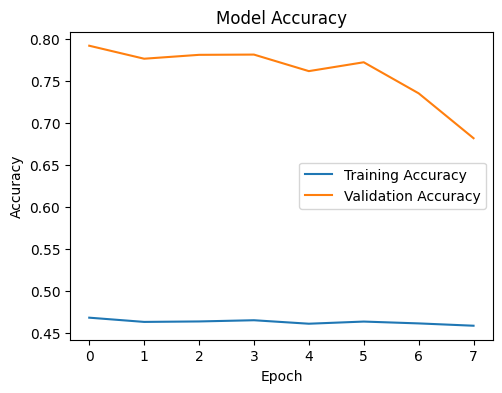

In [150]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


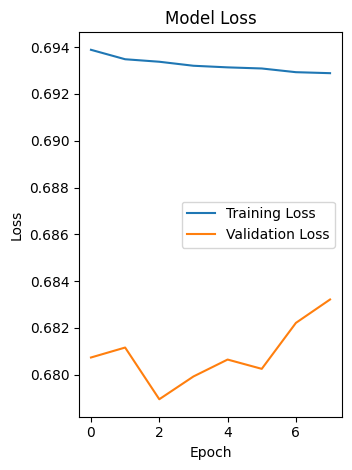

In [151]:

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


313/313 [==============================] - 1s 2ms/step


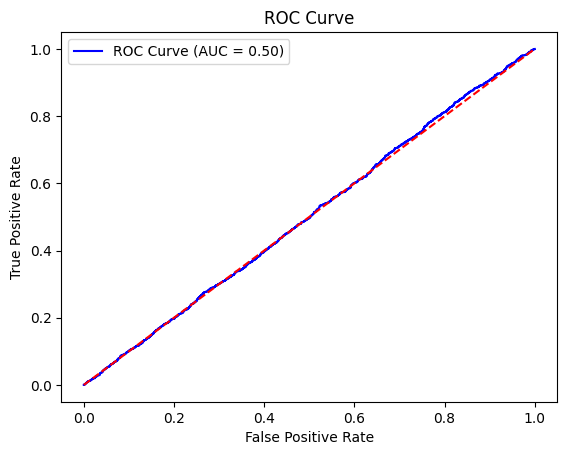

In [152]:

# ROC Curve and AUC
y_pred_prob = model.predict([X_test_cnn, X_test_lstm]).flatten()
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


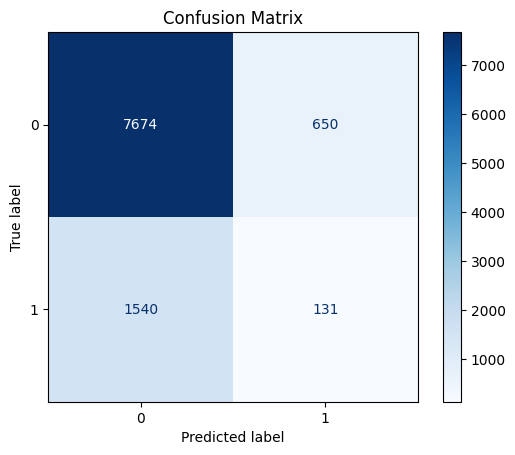

In [168]:

# Confusion Matrix
y_pred = (y_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("Confusion Matrix.png")
plt.show()
